In [1]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
import matplotlib 

from itertools import product

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

import h5py
from dustapprox.models import PrecomputedModel

import emcee
import corner

In [2]:
# ### Query Bayestar dustmap ###
# bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'

# bayestar = BayestarQuery(bayestar_path, version='bayestar2019')
# bayestar_dist = (bayestar.distances.to(u.pc)).value
# # distance = bayestar_dist[np.where(bayestar_dist < 1001)[0]]
distance = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 200)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

# reddening = 2.742 * bayestar(coords, mode='percentile', pct = (50, 16, 84)).astype(float) #Av, from https://iopscience.iop.org/article/10.1088/0004-637X/737/2/103#apj398709t6
# print(reddening.shape)

(200, 200, 200)


shape: (601, 601, 161)
(601, 601, 161)


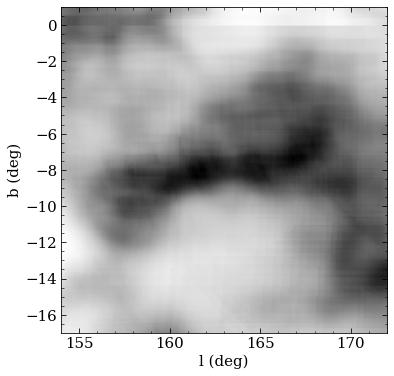

In [3]:
### Get Vergely+ (2022) dustmap for same points as Bayestar, now that it's in dustmaps
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')
vergely = vergelyquery(coords) * A0Coeff

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
plt.show()

In [4]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [5]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '../Data/230420_CAResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [6]:
CA_meta['DIST'][CA_meta['DIST'] < 0] = 0
verg_stars = np.zeros((len(CA_meta), len(distance)))
for i, star in enumerate(CA_meta):
    dinds = distance < star['DIST']

    verg_star = vergelyquery(SkyCoord(star['GLON'] * u.deg, star['GLAT']*u.deg, 
                                    distance=distance[dinds]*u.pc, frame = 'galactic'))
    verg_stars[i, dinds ] = verg_star


In [7]:
print(CA_meta.keys())

['APOGEE_ID', 'TELESCOPE', 'FIELD', 'RA', 'DEC', 'GLON', 'GLAT', 'J', 'H', 'K', 'AK_TARG', 'AK_WISE', 'VHELIO_AVG', 'GAIAEDR3_PARALLAX', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'ASPCAP_CHI2_1', 'MEDRES_NBIN', 'FILE', 'DIST', 'SFD_EBV', 'SNR', 'ASPCAPFLAG', 'STARFLAG', 'ASPCAP_CHI2_2', 'CONT_SHIFT', 'VERG_AV', 'VERG_AV_ERR', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']


In [8]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

for i in range(100):
    asdf = get_ca_res(CA_meta[i]['FILE'])
    try:
        fits.open(asdf)
    except:
        print('file doesnt exist')

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [9]:
# loff = 1
# boff = 1

loff = 1
boff = 1
l_cen, b_cen, = (163 + loff , -8.4 + boff)
s= select_stars(CA_meta, l_cen, b_cen, radius = .4)

In [10]:
np.nanmax(CA_meta['DIST'])

1405.2418

In [11]:
def find_nearest(ll, bb):
    l_sel = l_
    b_sel = b_

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[b_ind, l_ind, :])

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

# dAV_dd_star(l0, b0, (300, 480), CA_meta[sel1]['DIST'])


def Differential_Amplitude(dAv_dd, dd):
     return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd

    # dmin, dmax = bin_edges
    # dustmap_values = vergely()


In [12]:
def stack_DIBs(tab, return_unstacked = False):
    dib_array = np.zeros((len(tab), len(wavs_window)))
    dib_errs = np.zeros((len(tab), len(wavs_window)))
    for i in range(len(tab)):
        star = tab[i]

        try:
            res = fits.open(get_ca_res(star['FILE']))
            dib_array[i, :] = res[1].data[window]
            dib_errs[i, :] = res[2].data[window]
        except:
            dib_array[i, :] = np.nan
            dib_errs[i, :] = np.nan

    if return_unstacked:
        return np.nanmedian(dib_array, axis = 0), dib_array
    return np.nanmedian(dib_array, axis = 0), np.nanmedian(dib_errs, axis = 0)

In [13]:
def get_dist_bins(n, l_cen, b_cen, rad = 0.4, min_dist = 300, max_dist = 1000):
    select = select_stars(CA_meta, l_cen, b_cen, radius = rad)

    n_sightline = len(select)
    distances = CA_meta['DIST'][select]
    n_near = len(np.where(distances < min_dist))


    if (n_sightline - n_near) < (n-1): 
        print('WARNING: NOT ENOUGH STARS IN SIGHTLINE')
        n = n_sightline 
        print('NEW BIN NUMBER {}'.format(n))
    if n_near == 0: 
        print('WARNING: SIGHTLINE CONTAINS NO STARS AT DIST < {} PC; '.format(min_dist))
        min_dist = np.nanmin(distances)
        print('NEW MIN DIST {} PC'.format(min_dist))

    n_per_bin = (n_sightline - n_near) // (n-1)
    n_extra = (n_sightline - n_near) % (n-1)

    if max_dist is not None:
        max_dist = np.nanmax(distances)
    dist_range = max_dist - min_dist

    dist_bin_avg = dist_range / (n-1)
    
    dist_bin_borders = np.arange(min_dist, max_dist + 1, dist_bin_avg)

    iterate = True
    iters = 0 

    while iterate == True:
        iters = iters + 1 
        n_in_bin = np.array([len(np.where((distances > dist_bin_borders[i]) & (distances <= dist_bin_borders[i+1]))) 
                             for i in range(len(dist_bin_borders)-1)])

        ##FIGURE THIS OUT
        

In [14]:
### Get code to extract the necessary stellar residuals ###
dist_bins = np.array([np.nanmin(CA_meta['DIST']), np.nanmean(CA_meta['DIST']), np.nanmax(CA_meta['DIST'])])
# dist_bins = np.array([300, np.nanpercentile(CA_meta['DIST'], 33), np.nanpercentile(CA_meta['DIST'], 66)
#                       , np.nanmax(CA_meta['DIST'])])
dist_bins = np.array([300, np.nanpercentile(CA_meta['DIST'][s], 25), np.nanpercentile(CA_meta['DIST'][s], 50), np.nanpercentile(CA_meta['DIST'][s], 75)
                      , np.nanmax(CA_meta['DIST'][s])])
dist_bins[0] = 300
print(dist_bins)

voxel_dAv_dd = np.zeros(len(dist_bins))
signals = np.zeros((len(dist_bins), len(window_inds)))
signal_errs = np.zeros((len(dist_bins), len(window_inds)))


for i in range(len(dist_bins) - 1):
    bin_min, bin_max = (dist_bins[i], dist_bins[i+1])

    sel = np.where((CA_meta['DIST'][s] > bin_min) & (CA_meta['DIST'][s] <= bin_max))[0]
    # sel2 = np.where(CA_meta['DIST'][s] > dist_bins[1])[0]


# loff = 1
# boff = 5
    # voxel_av1 = dAV_dd(l_cen, b_cen, (bin_min, bin_max))
    voxel_av_ = dAV_dd_star(l_cen, b_cen, (bin_min, bin_max), CA_meta[s][sel]['DIST'])

    # voxel_amp1 = Differential_Amplitude(voxel_av1, 5 )
    voxel_amp_ = Differential_Amplitude(voxel_av_, 5 )

    voxel_dAv_dd[i+1] = voxel_av_ 

    dstack, derrs = stack_DIBs(CA_meta[s][sel])
    signals[i+1, :] = dstack
    signal_errs[i+1, :] = derrs

    

    # voxel_av2 = dAV_dd(l_cen, b_cen, tuple(dist_bins[1:]))
    # voxel_av2_ = dAV_dd_star(l_cen, b_cen, tuple(dist_bins[1:]), CA_meta[s][sel2]['DIST'])
    # voxel_amp2 = Differential_Amplitude(voxel_av2, 5)
    # voxel_amp2_ = Differential_Amplitude(voxel_av2_, 5)

# print(voxel_av1 * 5, voxel_av2 * 5)
# print(voxel_amp1, voxel_amp2)

# print(voxel_av1_ * 5, voxel_av2_ * 5)
# print(voxel_amp1_, voxel_amp2_)

voxel_av0 = dAV_dd(l_cen, b_cen, (0, dist_bins[0])) # Av for pre-sample stars 
# voxel_amp0 = Differential_Amplitude(voxel_av0, 5)
# print('Before Cloud: ', voxel_av0, voxel_amp0)
voxel_dAv_dd[0] = voxel_av0

sel0 = CA_meta['DIST'][s] < dist_bins[0]
# print(sel0)
signals[0, :], signal_errs[0, :] = stack_DIBs(CA_meta[s][sel0])
print(signals)
if np.any(np.isnan(signals)):
    print('ABORT')

# print(len(sel1), len(sel2))

[300.         417.1272583  469.88357544 522.91851807 573.24346924]
[[0.99721187 0.99841472 1.00026164 1.00002951 0.99728921 0.99428042
  0.99201872 0.99031748 0.99088176 0.9966786  1.00299041 1.00123775
  0.99723113 0.99916415 1.00028283 0.995791   0.99407334 0.99841519
  0.99755284 0.99303234 0.99542492 0.99769927 0.99088554 0.98925756
  0.9997043  1.00644867 1.00526151 1.0049665  1.00288202 0.9972753
  0.99773426 1.00310678 1.00312835 0.99841609 0.99565905 0.99522855
  0.9957573  0.99928491 1.00184374 1.00027213 0.99920608 1.00117891
  1.00246215 1.00002405 0.99572161 0.9957624  0.99953753 1.00109503
  0.99789671 0.99354862 0.99335542 0.99671429 0.99974492 0.99934169
  0.99695336 0.99619514 0.99973319 1.00414065 1.00508719 1.00331773
  1.00323533 1.00504272 1.0040852  1.00401095 1.00711235 1.00674354
  1.00224229 1.00179316 1.00457299 1.00510652 1.00294729 1.00002423
  0.99929672 1.00353967 1.00742045 1.00527568 1.00286939 1.00397717
  1.00339083 1.0024272  1.00325119 1.00234476 1.00

In [15]:
np.nanpercentile(CA_meta['DIST'], 20)

431.60267333984376

In [16]:
# voxel_dAv_dd = np.array([voxel_av0, voxel_av1_, voxel_av2_])
# voxel_dist = np.array([300, 486, 800])
voxel_dist = dist_bins

In [17]:
# fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
# axs[0].imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
# axs[0].set_xlabel('l (deg)')
# axs[0].set_ylabel('b (deg)')
# axs[0].scatter(CA_meta['GLON'][s], CA_meta['GLAT'][s])

# l_ind, b_ind = find_nearest(l_cen, b_cen)
# axs[1].plot(distance, vergely[b_ind, l_ind, :] * 5)


# norm_array = np.array([dist_bins[1]-dist_bins[0], dist_bins[1]-dist_bins[0], dist_bins[2] - dist_bins[1], dist_bins[2] - dist_bins[1]])
# # axs[1].plot([dist_bins[0], dist_bins[1], dist_bins[1], dist_bins[2]], np.array([voxel_av1, voxel_av1, voxel_av2, voxel_av2]) / 5)
# axs[1].plot([dist_bins[0], dist_bins[1], dist_bins[1], dist_bins[2]], np.array([voxel_av_, voxel_av1_, voxel_av2_, voxel_av2_]) / norm_array)

# axs[1].scatter(CA_meta['DIST'][s], np.ones(len(CA_meta[s])) * 0.07)
# plt.show()

In [18]:
# fig, ax = plt.subplots()

# for i, star in enumerate(CA_meta[sel2]):
#     ax.plot(distance, verg_stars[i, :], linestyle = 'dashed', alpha = .5, color = 'grey')
# ax.plot(distance, vergely[b_ind, l_ind, :])

In [19]:
# b_ind, l_ind

In [20]:
def stack_DIBs(tab, return_unstacked = False):
    dib_array = np.zeros((len(tab), len(wavs_window)))
    dib_errs = np.zeros((len(tab), len(wavs_window)))
    for i in range(len(tab)):
        star = tab[i]

        try:
            res = fits.open(get_ca_res(star['FILE']))
            dib_array[i, :] = res[1].data[window]
            dib_errs[i, :] = res[2].data[window]
        except:
            dib_array[i, :] = np.nan
            dib_errs[i, :] = np.nan

    if return_unstacked:
        return np.nanmedian(dib_array, axis = 0), dib_array
    return np.nanmedian(dib_array, axis = 0), np.nanmedian(dib_errs, axis = 0)

# dstack0, derrs0 = stack_DIBs(CA_meta[CA_meta['DIST'] < 300])
# dstack1, derrs1 = stack_DIBs(CA_meta[s][sel1])
# dstack2, derrs2 = stack_DIBs(CA_meta[s][sel2])

# # for i in

In [21]:
# signals = np.array([dstack0, dstack1, dstack2])
# signal_errs = np.array([derrs0, derrs1, derrs2])

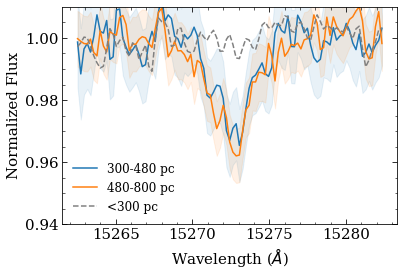

In [22]:
fig, ax = plt.subplots()
# for i in range(len(dstack)):
#     ax.plot(wavs_window, dstack1[i, :], linewidth = 1, color = 'grey', alpha = 0.5)

ax.plot(wavs_window, signals[1, :], label = '300-480 pc')
ax.fill_between(wavs_window, signals[1, :] + signal_errs[1, :], signals[1, :] - signal_errs[1, :], color= 'C0', alpha = 0.1)

ax.plot(wavs_window, signals[2, :], label = '480-800 pc')
ax.fill_between(wavs_window, signals[2, :] + signal_errs[2, :], signals[2, :] - signal_errs[2, :], color= 'C1', alpha = 0.1)

ax.plot(wavs_window, signals[0, :], label = '<300 pc', color = 'grey', linestyle = 'dashed')



# ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1), label = '$\sum$ voxel A(V)', c = 'C0',)
# ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1 + voxel_amp2), c = 'C1',)


# ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1_), c = 'C0', marker = '+', label = 'Med stellar A(V)')
# ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1_ + voxel_amp2_), marker = '+', c = 'C1')
# ax.scatter(lambda0, 1 - (voxel_amp0), c = 'k', marker = 'x', label = '< 300 pc')


ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.legend(fontsize = 12)
ax.set_ylim(0.94, 1.01)
plt.show()

In [23]:
def make_signals(rvelo, m = 0, b = 1, dAv_dd = voxel_dAv_dd, dist = voxel_dist, sigma0=sigma0, **kwargs):
    signals = np.zeros((len(dist), len(wavs_window)))
    amp = Differential_Amplitude(dAv_dd, dd = 5) # CONVERT THIS


    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(dist), 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))

    def single_signal(dist_max, i, amp = amp):
        # print(dist_max)
        amp = -np.copy(amp)
        amp[dist > dist_max] = 0
        voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        continuum = lambda x, m, b : m * (x - lambda0) + b
        cont = continuum(wavs_window, m, b)

        return summed_DIB  + cont
    

    for i in range(len(dist)):
        dist_max = dist[i]
        signals[i, :] = single_signal(dist_max, i)
    
    signals = signals #+ continuum(wavs_window, m, b)[np.newaxis, :]
    return signals


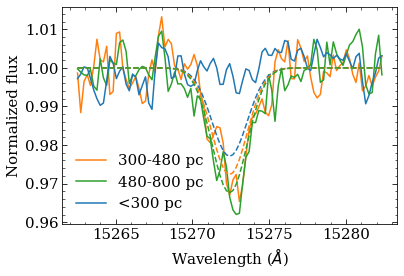

In [24]:
fig, ax = plt.subplots()

sig = make_signals(np.zeros(len(voxel_dist)))

ax.plot(wavs_window, signals[1, :], label = '300-480 pc', c = 'C1')
ax.plot(wavs_window, signals[2, :], label = '480-800 pc', color = 'C2')
ax.plot(wavs_window, signals[0, :], label = '<300 pc', color = 'C0')


for i in range(3):

    ax.plot(wavs_window, sig[i, :], c = 'C{}'.format(i), linestyle = 'dashed')


ax.legend()
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized flux' )

# ax.text(15262, 1.01, 'continuum = $-(1e-4) (\lambda - \lambda0) + 1.005$' , fontsize = 14)
plt.show()

In [25]:
### Log-likelihood etc. for first MCMC pass ###

def loglikely_2(p, sigma = signal_errs, signal = signals, **kwargs):
    v = p[:int(len(p)/2)]
    av = p[int(len(p)/2):]
    return - 0.5 * np.sum((signal - make_signals(v, dAv_dd = av, sigma0 = sigma0, **kwargs))**2 / (sigma**2)) 

def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        return -np.inf
    return 0.0

def logprior_av(av, AV_base = voxel_dAv_dd, AV_max = 1):   
    if (np.any(np.abs(av - AV_base) > AV_max)):
        return -np.inf
    if ((np.any(av < 0))):
        return -np.inf
    return 0.0

def logprob_2(p, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    # print('......')
    # print(p.shape)
    # print(p)
    # print('......')
    v = p[ :int(len(p)/2)]
    av = p[int(len(p)/2):]
    # sig = p[-1]
    lp = logprior(v, **kwargs)
    lp_av = logprior_av(av)

    if (not np.isfinite(lp)) | (not np.isfinite(lp_av)):
        return -np.inf
    return lp + lp_av + loglikely(p, **kwargs)

In [26]:
def loglikely(p, sigma = signal_errs, signal = signals, **kwargs):
    v = p
    # m = p[:, 3] / 10
    # m = 0
    # b = p[:, 3] / 10
    # print(b)
    # b = 1
    return - 0.5 * np.sum((signal - make_signals(v, **kwargs))**2 / (sigma**2)) 

def logprior(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        return -np.inf
    return 0.0

def logprob(v, logprior = logprior, loglikely = loglikely, **kwargs):
    lp = logprior(v, **kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikely(v, **kwargs)

In [27]:
ndim = len(voxel_dist) 
ndim_amp = int(2 * ndim)
def MCMC1(dAV_dd, steps = 1000, nwalkers = 100):


    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs})
    init = 5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init[:, ndim:] = np.abs(dAV_dd[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
    
    sampler.run_mcmc(init,  steps);
    
    return sampler

def MCMC2(dAV_dd, init, steps = 1000, nwalkers = 100):
    ndim = len(voxel_dist) 
    sampler = emcee.EnsembleSampler(nwalkers, ndim , logprob, 
                                    kwargs  = {'prior_mult':  3, 'v_max': 10, 'sigma': signal_errs})

    sampler.run_mcmc(init, steps)

    return sampler 

In [28]:
# make_signals(vel, dAv_dd = voxel_dAv_dd)

In [29]:
# samples = samp1.chain[:, :, :].reshape((-1, ndim_amp))
# np.nanmedian(samples, axis = 1)

In [30]:
samp1 = MCMC1(voxel_dAv_dd, steps=500)

init = samp1.chain[:,-1, :ndim]
samples = samp1.chain[:, :, :].reshape((-1, ndim_amp))
med_dAV_dd = np.nanmedian(samples[50:, ndim:], axis = 0)

samp2 = MCMC2(med_dAV_dd, init, steps = 500)

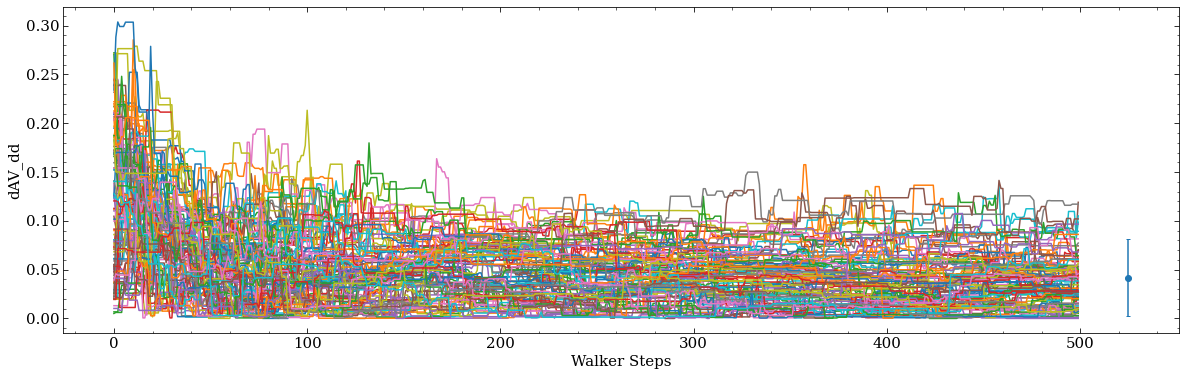

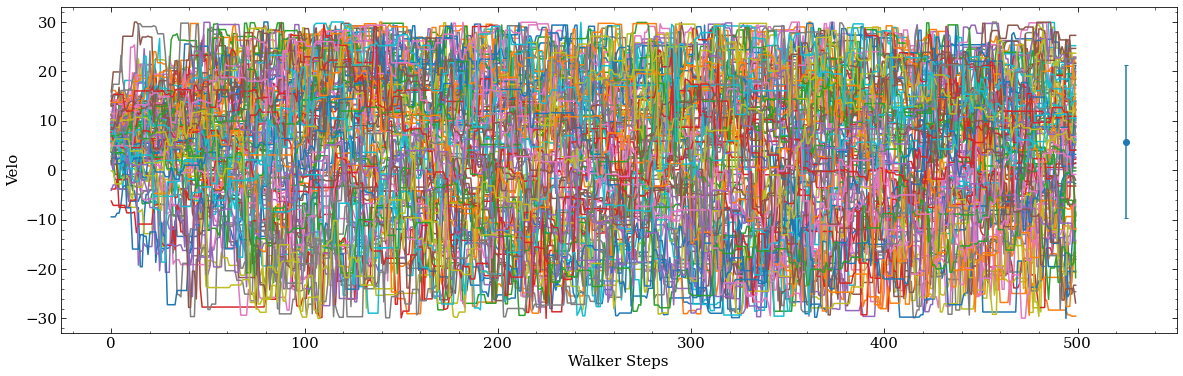

In [31]:
def burnin(sampler, i, label = ''):
    fig, ax = plt.subplots(figsize = (20, 6))

    normalize = matplotlib.colors.Normalize(-10, 10)
    cmap = matplotlib.cm.viridis
    cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
    colors = cmap(np.linspace(0,1,ndim))

    # for i in range(ndim):
    walkers = sampler.chain[:,:,i].T
    points = ax.plot(walkers)

    cutoff = 100
    median = np.median(walkers[100:, :])
    perc16err =  median - np.percentile(walkers[100:, :], 16) 
    perc84err =  np.percentile(walkers[100:, :], 84) - median
    stdeviation =  np.std(walkers[100,:], ddof = 1)


    plt.errorbar(x = 500 + 0.05 * 500, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

    # fig.colorbar(cmappable, label = 'Velocity ')
    ax.set_xlabel("Walker Steps")
    ax.set_ylabel(label)
    plt.show()

burnin(samp1, -1, label = 'dAV_dd')
burnin(samp2, 1, label = 'Velo')

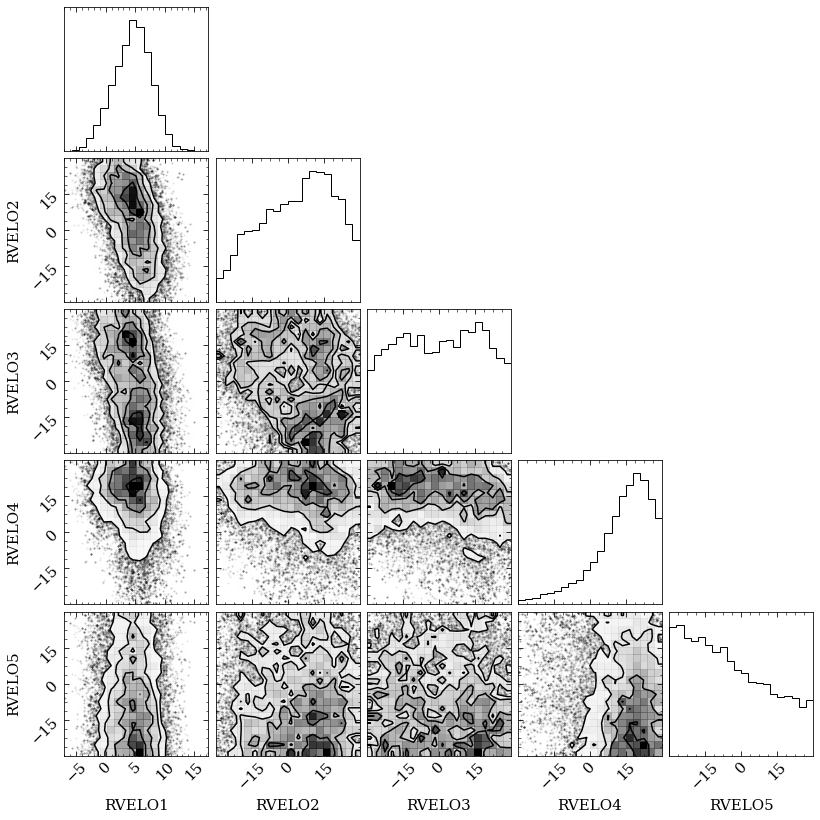

In [32]:
def make_corner(sampler, labels):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, 50:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

labels = ['RVELO1', 'RVELO2', 'RVELO3', 'RVELO4', 'RVELO5', 'RVELO6', 'RVELO7']
# make_corner(samp1, labels = labels)
make_corner(samp2, labels = labels)

In [33]:
def plot_DIBS(sampler):
    fig, ax = plt.subplots(figsize = (8,6))
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    median_0 = np.nanmedian(samples[50:, 0])
    median_1 = np.nanmedian(samples[50:, 1])
    median_2 = np.nanmedian(samples[50:, 2])
    # median_3 = np.nanmedian(samples[50:, 3])
    # median_4 = np.nanmedian(samples[50:, 4])
    # median_5 = np.nanmedian(samples[50:, 5])
    # median_6 = np.nanmedian(samples[50:, 6])
    print(samples.shape)
    medians = np.nanmedian(samples[50:, :], axis = 0)

    print(medians)
    print(medians.shape)


    std_1 = np.std(samples[50:, 1], ddof = 1)
    std_2 = np.std(samples[50:, 2], ddof = 1)

    signal_recreated = make_signals(medians, dAv_dd = med_dAV_dd, sigma0 = sigma0)
    for i in range(len(signal_recreated)):
        ax.plot(wavs_window, signals[i, :], color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[i, :], color = 'C{}'.format(i), linestyle = 'dashed', label = 'recreated signal')
        # ax.plot(wavs_window, signal_recreated[2, :], color = 'C1', linestyle = 'dashed')

    ax.legend(loc = 'lower left')

    ax.set_xlabel('Wavelength $\AA$')
    ax.set_ylabel('Normalized Flux')
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))

    plt.show()

(45000, 5)
[ 4.57973317  5.78913668  0.74745563 15.70696748 -7.53681205]
(5,)


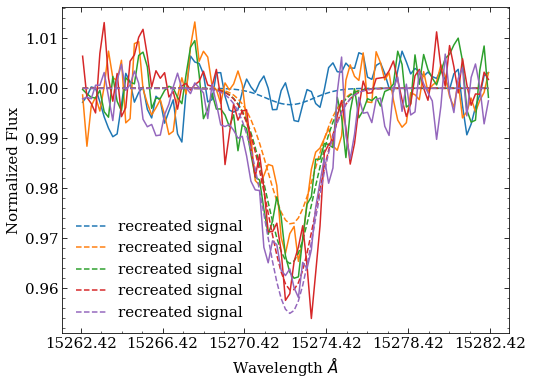

In [34]:
plot_DIBS(samp2)


<ErrorbarContainer object of 3 artists>

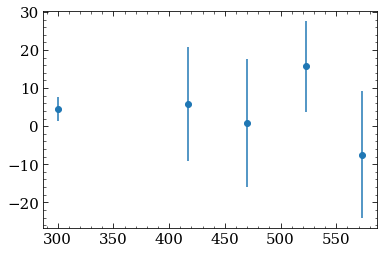

In [35]:
samples = samp2.chain[:, 50:, :].reshape((-1, samp2.chain.shape[-1]))
velo_median = np.nanmedian(samples[50:, :], axis = 0)
velo_stdev = np.nanstd(samples[50:, :], axis = 0)

fig, ax = plt.subplots()
ax.scatter(voxel_dist, velo_median, zorder = 3)
ax.errorbar(voxel_dist, velo_median, yerr = velo_stdev, fmt = '.')



In [36]:
# fig, ax = plt.subplots(figsize = (20, 6))

# normalize = matplotlib.colors.Normalize(-10, 10)
# cmap = matplotlib.cm.viridis
# cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
# colors = cmap(np.linspace(0,1,ndim))

# # for i in range(ndim):
# i = -1
# walkers = samp2.chain[:,:,i].T
# print(walkers.shape)
# points = ax.plot(walkers)

# cutoff = 100
# median = np.median(walkers[100:, :])
# perc16err =  median - np.percentile(walkers[100:, :], 16) 
# perc84err =  np.percentile(walkers[100:, :], 84) - median
# stdeviation =  np.std(walkers[100,:], ddof = 1)
# print(perc16err)
# print(median)
# print(perc84err)


# plt.errorbar(x = steps + 0.05 * steps, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

# # fig.colorbar(cmappable, label = 'Velocity ')
# ax.set_xlabel("Walker Steps")
# # ax.set_ylabel('Radial Velocity (km/s)')
# plt.show()

In [37]:
# samples = sampler.chain[:, 50:, :].reshape((-1, ndim_amp))

# # median_3 = np.nanmedian(samples[50:, 3])
# # median_4 = np.nanmedian(samples[50:, 4])
# # median_5 = np.nanmedian(samples[50:, 5])
# samples.shape

In [38]:
# sampler.chain.shape


In [39]:
# nwalkers = 100 # + 50 + 50 + 50
# ndim = len(voxel_dist)
# ndim = len(voxel_dist) 
# ndim_amp = int(2 * ndim)
# prior_mult = 2

# sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, kwargs  = {'prior_mult':  4, 'v_max': 5, 'sigma': signal_errs})

# init = 5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
# init[:, ndim:] = np.abs(voxel_dAv_dd[np.newaxis, :] + 0.5*(np.random.random(init[:, 3:].shape)-0.5))

In [40]:
# voxel_dAv_dd

In [41]:
# fig, ax = plt.subplots(figsize = (20, 6))

# normalize = matplotlib.colors.Normalize(-10, 10)
# cmap = matplotlib.cm.viridis
# cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
# colors = cmap(np.linspace(0,1,ndim))

# # for i in range(ndim):
# i = -1
# walkers = sampler.chain[:,:,i].T
# print(walkers.shape)
# points = ax.plot(walkers)

# cutoff = 100
# median = np.median(walkers[100:, :])
# perc16err =  median - np.percentile(walkers[100:, :], 16) 
# perc84err =  np.percentile(walkers[100:, :], 84) - median
# stdeviation =  np.std(walkers[100,:], ddof = 1)
# print(perc16err)
# print(median)
# print(perc84err)


# plt.errorbar(x = steps + 0.05 * steps, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

# # fig.colorbar(cmappable, label = 'Velocity ')
# ax.set_xlabel("Walker Steps")
# # ax.set_ylabel('Radial Velocity (km/s)')
# plt.show()

In [42]:
# labels = ['{} pc'.format(i) for i in ['<300', '300-480', '>480']]
# print(labels)
# samples = sampler.chain[:, 50:, :].reshape((-1, ndim_amp))

# median_3 = np.nanmedian(samples[50:, 3])
# median_4 = np.nanmedian(samples[50:, 4])
# median_5 = np.nanmedian(samples[50:, 5])
# dAV_dd_mc = np.array([median_3, median_4, median_5])


# fig = corner.corner(samples, figsize = (20, 20))
# for ax in fig.axes:
    # ax.set_xlim(-10, 10)
    # ax.set_ylim(-20, 20) 
# plt.show()

In [43]:
# chain = sampler.chain
# init = chain[:, -1, :3]

In [44]:
# ndim = len(voxel_dist) 

# sampler = emcee.EnsembleSampler(nwalkers, ndim , logprob, kwargs  = {'prior_mult':  prior_mult, 'v_max': 10, 'sigma': signal_errs})
# # init =  np.tile(voxel_rvelo, nwalkers).reshape((nwalkers, ndim)) + np.random.normal(0, 1/np.sqrt(SNR), (nwalkers, ndim))
# # init = 5 *(np.random.random((nwalkers, ndim)) - 0.5)
# init[:, -1] = 2 + np.random.random(nwalkers) 
# init = np.hstack([init, 10 * np.ones(nwalkers).T[:, np.newaxis]])

In [45]:
# labels = ['{} pc'.format(i) for i in ['<300', '300-480', '>480']]
# print(labels)
# samples = sampler.chain[:, 50:, :].reshape((-1, 3))
# fig = corner.corner(samples, figsize = (20, 20), labels = ['1', '2', '3'])
# # for ax in fig.axes:
#     # ax.set_xlim(-10, 10)
#     # ax.set_ylim(-20, 20) 
# plt.show()

In [46]:
# sampler.chain.shape

In [47]:
# fig, ax = plt.subplots(figsize = (20, 6))

# normalize = matplotlib.colors.Normalize(-10, 10)
# cmap = matplotlib.cm.viridis
# cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
# colors = cmap(np.linspace(0,1,ndim))

# # for i in range(ndim):
# i = 1
# walkers = sampler.chain[:,:,i].T
# print(walkers.shape)
# points = ax.plot(walkers)

# cutoff = 100
# median = np.median(walkers[100:, :])
# perc16err =  median - np.percentile(walkers[100:, :], 16) 
# perc84err =  np.percentile(walkers[100:, :], 84) - median
# stdeviation =  np.std(walkers[100,:], ddof = 1)
# print(perc16err)
# print(median)
# print(perc84err)


# plt.errorbar(x = steps + 0.05 * steps, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

# # fig.colorbar(cmappable, label = 'Velocity ')
# ax.set_xlabel("Walker Steps")
# ax.set_ylabel('Radial Velocity (km/s)')
# plt.show()

In [48]:
voxel_dAv_dd

array([0.19072251, 0.03965239, 0.03917499, 0.05762405, 0.02641265])

In [49]:
med_dAV_dd

array([0.02729127, 0.19893008, 0.06705275, 0.05003496, 0.04474356])

In [50]:
# samples = samp2.chain[:, 50:, :].reshape((-1, samp2.chain.shape[-1]))
# vel = np.nanmedian(samples, axis = 0)
# make_signals(vel, dAv_dd = med_dAV_dd)

In [51]:
# fig, ax = plt.subplots(figsize = (8,6))
# ax.plot(wavs_window, dstack1, label = '300-480 pc')
# ax.plot(wavs_window, dstack2, label = '480-800 pc')

# median_0 = np.nanmedian(samples[50:, 0])
# median_1 = np.nanmedian(samples[50:, 1])
# median_2 = np.nanmedian(samples[50:, 2])
# # median_3 = np.nanmedian(samples[50:, 3])
# # median_4 = np.nanmedian(samples[50:, 4])
# # median_5 = np.nanmedian(samples[50:, 5])
# # median_6 = np.nanmedian(samples[50:, 6])


# std_1 = np.std(samples[50:, 1], ddof = 1)
# std_2 = np.std(samples[50:, 2], ddof = 1)

# signal_recreated = make_signals(np.array([median_0, median_1, median_2]),dAv_dd = dAV_dd_mc, sigma0 = sigma0)
# ax.plot(wavs_window, signal_recreated[1, :], color = 'C0', linestyle = 'dashed', label = 'recreated signal')
# ax.plot(wavs_window, signal_recreated[2, :], color = 'C1', linestyle = 'dashed')

# ax.legend(loc = 'lower left')

# ax.set_xlabel('Wavelength $\AA$')
# ax.set_ylabel('Normalized Flux')
# fig.set_facecolor('white')

# ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))

# plt.show()

In [52]:
# DIB-AV relationship of stars in individual bins, and of the bins themselves

In [53]:
# fig, ax = plt.subplots()
# ax.scatter([0,1],[median_1, median_2])
# ax.errorbar([0,1], [median_1, median_2], yerr = [std_1, std_2], fmt = '.')
# ax.set_xticks([0, 1])